<a href="https://colab.research.google.com/github/megha-puthukudi/main-project/blob/InceptionResNet50/inceprion_spot_10epochs_32_batch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Found 840 images belonging to 3 classes.
Found 180 images belonging to 3 classes.
Found 180 images belonging to 3 classes.
219055592/219055592 [==============================] - 4s 0us/step
Epoch 1/10
26/26 [==============================] - 327s 12s/step - loss: 1.3358 - accuracy: 0.3354 - val_loss: 1.0925 - val_accuracy: 0.3562
Epoch 2/10
26/26 [==============================] - 27s 1s/step - loss: 1.2543 - accuracy: 0.3564 - val_loss: 1.0757 - val_accuracy: 0.4000
Epoch 3/10
26/26 [==============================] - 27s 1s/step - loss: 1.2031 - accuracy: 0.3787 - val_loss: 1.0669 - val_accuracy: 0.4250
Epoch 4/10
26/26 [==============================] - 27s 1s/step - loss: 1.2097 - accuracy: 0.3800 - val_loss: 1.0606 - val_accuracy: 0.4250
Epoch 5/10
26/26 [==============================] - 28s 1s/step - loss: 1.2357 - accuracy: 0.3700 - val_loss: 1.0499 - val_accuracy: 0.4563
Epoch 6/10
26/26 [==============================] - 28s 1s/step - loss: 1.1764 - accuracy: 0.3837 - val_loss

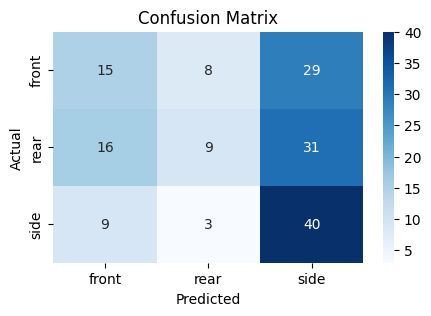

Test loss: 1.0429
Test accuracy: 43.75
Train loss: 1.0313
Train accuracy: 47.24
Recall: 0.41
Precision: 0.41
F1-score: 0.36


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix
import seaborn as sns  # Added seaborn for visualization

# Define your data directories
train_dir = '/content/drive/MyDrive/spot - Copy/train'
val_dir = '/content/drive/MyDrive/spot - Copy/validation'
test_dir = '/content/drive/MyDrive/spot - Copy/test'

# Define image size and batch size
img_size = (299, 299)  # Adjusted for InceptionResNetV2
batch_size = 32  # Increase batch size for faster convergence

# Create data generators with more aggressive data augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input,  # Update to InceptionResNetV2 preprocessing
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)  # Update to InceptionResNetV2 preprocessing
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)  # Update to InceptionResNetV2 preprocessing

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Load the pre-trained InceptionResNetV2 model
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(299, 299, 3))  # Adjusted input shape

# Add a global average pooling layer
x = GlobalAveragePooling2D()(base_model.output)

# Add dropout for regularization
x = Dropout(0.5)(x)

# Add a dense output layer with softmax activation
predictions = Dense(3, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers in the base model except the last few
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with early stopping
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=10,
    validation_data=val_generator,
    validation_steps=val_generator.n // batch_size,
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.n // batch_size)
train_loss, train_accuracy = model.evaluate(train_generator, steps=train_generator.n // batch_size)

# Calculate recall
y_true = []
y_pred = []
for i in range(test_generator.n // batch_size):
    batch_x, batch_y = next(test_generator)
    y_true.extend(np.argmax(batch_y, axis=1))
    y_pred.extend(np.argmax(model.predict(batch_x), axis=1))

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['front', 'rear', 'side'], yticklabels=['front', 'rear', 'side'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate other metrics
recall = recall_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
# Display metrics
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_accuracy * 100:.2f}')
print(f'Train loss: {train_loss:.4f}')
print(f'Train accuracy: {train_accuracy * 100:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Precision: {precision:.2f}')
print(f'F1-score: {f1:.2f}')

# Save the trained model
model.save('/content/drive/MyDrive/colabtest/vecicle_spot_position_InceptionResNetV2_epoch_10_dataset.h5')


Found 840 images belonging to 3 classes.
Found 180 images belonging to 3 classes.
Found 180 images belonging to 3 classes.
Epoch 1/50
26/26 [==============================] - 41s 1s/step - loss: 1.1762 - accuracy: 0.3317 - val_loss: 1.1292 - val_accuracy: 0.3313
Epoch 2/50
26/26 [==============================] - 27s 1s/step - loss: 1.1413 - accuracy: 0.3614 - val_loss: 1.1319 - val_accuracy: 0.3438
Epoch 3/50
26/26 [==============================] - 28s 1s/step - loss: 1.1107 - accuracy: 0.3858 - val_loss: 1.1047 - val_accuracy: 0.3875
Epoch 4/50
26/26 [==============================] - 27s 1s/step - loss: 1.1006 - accuracy: 0.3676 - val_loss: 1.0960 - val_accuracy: 0.3625
Epoch 5/50
26/26 [==============================] - 28s 1s/step - loss: 1.0785 - accuracy: 0.4257 - val_loss: 1.0769 - val_accuracy: 0.3875
Epoch 6/50
26/26 [==============================] - 27s 1s/step - loss: 1.0638 - accuracy: 0.4270 - val_loss: 1.0678 - val_accuracy: 0.4187
Epoch 7/50
26/26 [===================

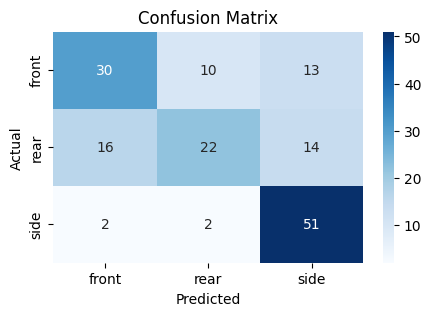

Test loss: 0.8293
Test accuracy: 63.13
Train loss: 0.8154
Train accuracy: 66.59
Recall: 0.64
Precision: 0.64
F1-score: 0.62


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix
import seaborn as sns  # Added seaborn for visualization

# Define your data directories
train_dir = '/content/drive/MyDrive/spot - Copy/train'
val_dir = '/content/drive/MyDrive/spot - Copy/validation'
test_dir = '/content/drive/MyDrive/spot - Copy/test'

# Define image size and batch size
img_size = (299, 299)  # Adjusted for InceptionResNetV2
batch_size = 32  # Increase batch size for faster convergence

# Create data generators with more aggressive data augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input,  # Update to InceptionResNetV2 preprocessing
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)  # Update to InceptionResNetV2 preprocessing
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)  # Update to InceptionResNetV2 preprocessing

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Load the pre-trained InceptionResNetV2 model
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(299, 299, 3))  # Adjusted input shape

# Add a global average pooling layer
x = GlobalAveragePooling2D()(base_model.output)



# Add a dense output layer with softmax activation
predictions = Dense(3, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers in the base model except the last few
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with early stopping
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=50,
    validation_data=val_generator,
    validation_steps=val_generator.n // batch_size,
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.n // batch_size)
train_loss, train_accuracy = model.evaluate(train_generator, steps=train_generator.n // batch_size)

# Calculate recall
y_true = []
y_pred = []
for i in range(test_generator.n // batch_size):
    batch_x, batch_y = next(test_generator)
    y_true.extend(np.argmax(batch_y, axis=1))
    y_pred.extend(np.argmax(model.predict(batch_x), axis=1))

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['front', 'rear', 'side'], yticklabels=['front', 'rear', 'side'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate other metrics
recall = recall_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
# Display metrics
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_accuracy * 100:.2f}')
print(f'Train loss: {train_loss:.4f}')
print(f'Train accuracy: {train_accuracy * 100:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Precision: {precision:.2f}')
print(f'F1-score: {f1:.2f}')

# Save the trained model
model.save('/content/drive/MyDrive/colabtest/vecicle_spot_position_InceptionResNetV2_epoch_50_dataset.h5')


Found 840 images belonging to 3 classes.
Found 180 images belonging to 3 classes.
Found 180 images belonging to 3 classes.
Epoch 1/100
26/26 [==============================] - 41s 1s/step - loss: 1.1693 - accuracy: 0.3379 - val_loss: 1.1484 - val_accuracy: 0.2313
Epoch 2/100
26/26 [==============================] - 28s 1s/step - loss: 1.1082 - accuracy: 0.3462 - val_loss: 1.1256 - val_accuracy: 0.2937
Epoch 3/100
26/26 [==============================] - 26s 1s/step - loss: 1.0928 - accuracy: 0.3899 - val_loss: 1.1162 - val_accuracy: 0.3250
Epoch 4/100
26/26 [==============================] - 26s 1s/step - loss: 1.0859 - accuracy: 0.3886 - val_loss: 1.0860 - val_accuracy: 0.3875
Epoch 5/100
26/26 [==============================] - 28s 1s/step - loss: 1.0475 - accuracy: 0.4435 - val_loss: 1.0746 - val_accuracy: 0.3812
Epoch 6/100
26/26 [==============================] - 28s 1s/step - loss: 1.0677 - accuracy: 0.4307 - val_loss: 1.0638 - val_accuracy: 0.4125
Epoch 7/100
26/26 [============

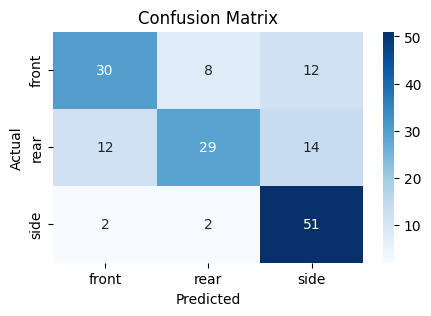

Test loss: 0.7789
Test accuracy: 66.25
Train loss: 0.7046
Train accuracy: 71.63
Recall: 0.68
Precision: 0.70
F1-score: 0.68


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix
import seaborn as sns  # Added seaborn for visualization

# Define your data directories
train_dir = '/content/drive/MyDrive/spot - Copy/train'
val_dir = '/content/drive/MyDrive/spot - Copy/validation'
test_dir = '/content/drive/MyDrive/spot - Copy/test'

# Define image size and batch size
img_size = (299, 299)  # Adjusted for InceptionResNetV2
batch_size = 32  # Increase batch size for faster convergence

# Create data generators with more aggressive data augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input,  # Update to InceptionResNetV2 preprocessing
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)  # Update to InceptionResNetV2 preprocessing
test_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)  # Update to InceptionResNetV2 preprocessing

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Load the pre-trained InceptionResNetV2 model
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(299, 299, 3))  # Adjusted input shape

# Add a global average pooling layer
x = GlobalAveragePooling2D()(base_model.output)



# Add a dense output layer with softmax activation
predictions = Dense(3, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers in the base model except the last few
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with early stopping
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=100,
    validation_data=val_generator,
    validation_steps=val_generator.n // batch_size,
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.n // batch_size)
train_loss, train_accuracy = model.evaluate(train_generator, steps=train_generator.n // batch_size)

# Calculate recall
y_true = []
y_pred = []
for i in range(test_generator.n // batch_size):
    batch_x, batch_y = next(test_generator)
    y_true.extend(np.argmax(batch_y, axis=1))
    y_pred.extend(np.argmax(model.predict(batch_x), axis=1))

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize the confusion matrix as a heatmap
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['front', 'rear', 'side'], yticklabels=['front', 'rear', 'side'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate other metrics
recall = recall_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')
# Display metrics
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_accuracy * 100:.2f}')
print(f'Train loss: {train_loss:.4f}')
print(f'Train accuracy: {train_accuracy * 100:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Precision: {precision:.2f}')
print(f'F1-score: {f1:.2f}')

# Save the trained model
model.save('/content/drive/MyDrive/colabtest/vecicle_spot_position_InceptionResNetV2_epoch_100_dataset.h5')
